## basic info

* 모든 데이터셋은 아시아인 남녀로 구성되어 있고 나이는 20대부터 70대까지 다양하게 분포
* 전체 사람 명 수 : 4,500 (train+eval)
    - 전체 데이터셋 중에서 60%는 학습 데이터셋. (2700)
* 한 사람당 사진의 개수: 7 - 마스크 착용 5장, 이상하게 착용(코스크, 턱스크) 1장, 미착용 1장
* 이미지 크기: (384, 512)
* 마스크 착용여부, 성별, 나이를 기준으로 총 18개의 클래스가 있다. 결과값으로 0~17에 해당되는 숫자가 각 이미지 당 하나씩 나와야 한다.
    - [클래스 및 추가 정보 확인](https://stages.ai/competitions/74/data/training)

## load data

### pandas dataframe 으로 데이터를 로드

In [3]:
import pandas as pd

In [4]:
train_path = '/opt/ml/input/data/train/'
data = pd.read_csv (train_path+"train.csv")
data.head(6)

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
5,000007,female,Asian,58,000007_female_Asian_58


## data preprocessing

### age 를 3개의 범위로 카테고리화 
새로운 age_category 라는 column 을 생성함
* low: <30 
* mid: >=30 and <60
* high: >=60

In [5]:
data['age_category'] = pd.cut(data['age'], bins=[0, 29, 59, 100], include_lowest=False, labels=[0,1,2])
data.head(3)

,id,gender,race,age,path,age_category
0,000001,female,Asian,45,000001_female_Asian_45,1
1,000002,female,Asian,52,000002_female_Asian_52,1
2,000004,male,Asian,54,000004_male_Asian_54,1


In [6]:
data.tail(3)

,id,gender,race,age,path,age_category
2697,006956,male,Asian,19,006956_male_Asian_19,0
2698,006957,male,Asian,20,006957_male_Asian_20,0
2699,006959,male,Asian,19,006959_male_Asian_19,0


In [7]:
data2 = data[['id','gender','age_category','path']]
data2.head()
data2.tail()

,id,gender,age_category,path
2695,006954,male,0,006954_male_Asian_19
2696,006955,male,0,006955_male_Asian_19
2697,006956,male,0,006956_male_Asian_19
2698,006957,male,0,006957_male_Asian_20
2699,006959,male,0,006959_male_Asian_19


## 18개 class 생성, mask 속성 추가 및 path 수정
ex) 기존 1개의 path를 000001_female_Asian_45 에서 000001_female_Asian_45/incorrect_mask.jpg, mask1.jpg, ...  mask5.jpg, normal.jpg 7개 path로 변경 

In [22]:
def find_category(gender,age,mask):
    category = -1
    #if 1<=mask<6:
    if mask==1:
        if gender=="male": #correct,male
            category = age
        else: #correct,female
            category = age+3
    elif mask==0:
        if gender=="male": #incorrect,male
            category = age+6
        else: #incorrect,female
            category = age+9
    else:
        if gender=="male": #notwear,male
            category = age+12
        else: #notwear,female
            category = age+15
    return category


import os
data3 = []
for i in range(len(data2)): #2700
    gender = data2['gender'][i]
    age = data2['age_category'][i]
    file_list = os.listdir(train_path+"images/"+data2['path'][i])
    j=0
    for filename in file_list:
        if "incorrect_mask" in filename : mask=0
        elif "mask" in filename: mask=1
        else: mask=2
        category = find_category(gender,age,mask)
        gender_num = 0 if gender=="male" else 1
        if "._" not in filename and "ipynb" not in filename:
            path = train_path+"images/"+data2['path'][i]+"/"+filename
            data3.append([format(i*7+j, '06d'),path,gender_num,age,category])
            j+=1

data4 = pd.DataFrame(data3, columns = ['id','path','gender','age','category'])

'''
import glob
data3 = []
for i in range(len(data2)): #2700
    gender = data2['gender'][i]
    age = data2['age_category'][i]
    for j,path in enumerate(glob.glob(train_path+"images/"+data2['path'][i]+"/*")):
        category = find_category(gender,age,j)
        gender_num = 0 if gender=="male" else 1
        data3.append([format(i*7+j, '06d'),path,gender_num,age,category])

data4 = pd.DataFrame(data3, columns = ['id','path','gender','age','category'])
'''
data4.head(10) #18900 rows × 3 columns


,id,path,gender,age,category
0,000000,/opt/ml/input/data/train/images/000001_female_...,1,1,4
1,000001,/opt/ml/input/data/train/images/000001_female_...,1,1,4
2,000002,/opt/ml/input/data/train/images/000001_female_...,1,1,10
3,000003,/opt/ml/input/data/train/images/000001_female_...,1,1,16
4,000004,/opt/ml/input/data/train/images/000001_female_...,1,1,4
5,000005,/opt/ml/input/data/train/images/000001_female_...,1,1,4
6,000006,/opt/ml/input/data/train/images/000001_female_...,1,1,4
7,000007,/opt/ml/input/data/train/images/000002_female_...,1,1,4
8,000008,/opt/ml/input/data/train/images/000002_female_...,1,1,4
9,000009,/opt/ml/input/data/train/images/000002_female_...,1,1,10


각 class 의미는 아래와 같다.

![클래스 종류](./class.JPG)

class 별 데이터 불균형을 확인할 수 있다.

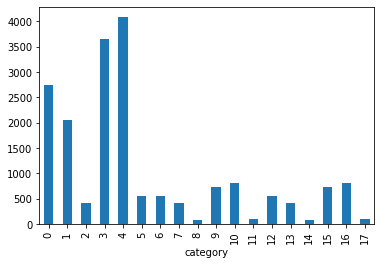

In [23]:
data4.groupby('category').count().id.plot(kind='bar')

## 결과 파일로 저장
전처리 결과를 csv 파일로 저장한다.

In [25]:
data4.to_csv(train_path+"train3.csv",index=False)

잘 저장된것을 확인할 수 있다.

![저장된 결과파일](./캡처.JPG)